In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
import math
from utils import *

In [2]:
def sig(x):
    return (1 / (1 + torch.exp(-x)))

def sig_d(x):
    s = sig(x)
    return s * (1 - s)

class Dense(torch.nn.Module):
    def __init__(self, n_in, n_out , sigmoid = True, pointwise = False):
        super(Dense, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.sigmoid = sigmoid
        self.pointwise = pointwise
        
        if not pointwise:
            self.weight = torch.zeros([n_in, n_out])
            
        else:
            if n_in != n_out:
                raise Exception('n_in must be equal to n_out for pointwise operation, {} and {} where given'.format(n_in,n_out))
            self.weight = torch.zeros([n_in,1] )
        self.weight += -1
        #self.reset_parameters()

    def forward(self, spikes):
        if not self.pointwise:
            a = torch.matmul(spikes,self.weight).squeeze()
        else:
            a = spikes * self.weight.squeeze() 
            
        if self.sigmoid:
            a = (sig(a)) * (a !=0) 
        
        return a

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        
    def weight_update(self, error, lr = 0.05):
        delta_w = sig_d(self.weight) * error * lr
        self.weight += delta_w    


In [3]:
class Spike1d(torch.nn.Module):
    def __init__(self, n_in,n_out, thresh = 0.5, input_connections = [], mod = False, verbose = False):
        super(Spike1d, self).__init__()
        self.potentials = Parameter(torch.zeros(n_out, dtype=torch.float),requires_grad=False)
        self.thresh = thresh
        self.mod = mod
        self.n_out = n_out
        self.n_in = n_in
        self.verbose = verbose
        
        #Create list of timing errors and weights for each connected layer
        fc = []
        timings = []
        for idx,i in enumerate(n_in):
            is_input = (idx in input_connections)
            fc.append(Dense(i,n_out , pointwise  = is_input))
            if not is_input:
                timings.append(torch.zeros([n_out, i]))
            else:
                timings.append(torch.zeros([n_out, 1]))
                    
        self.timings = timings
        self.fc = fc
                
    def get_empty_spikes(self):
        return torch.zeros([self.n_out])
    
    def get_n_inputs(self):
        return len(self.n_in)
    
    def forward(self, in_spikes, training = True):       
        #generate spikes and uptade potentials accordingly
        spikes = (self.potentials >= self.thresh).float()
        if self.mod:
            self.potentials = Parameter(self.potentials - (spikes * self.thresh))
        else:
            self.potentials = Parameter(self.potentials * (1 - spikes))
                    
        #Calculate errors
        errors = []
        for idx, timing in enumerate(self.timings):
            #Step timings
            timing += 1 * torch.sign(timing)
            
            #on in fire (Neurons want to fire sooner : weights are increased)
            if not self.fc[idx].pointwise: 
                timing = timing.transpose(0,1)
               
            positive_errors = []
            for t, s in zip(timing, in_spikes[idx]):
                if s == 1:
                    if self.verbose:
                        print("spike received from side {}".format(idx))

                    positive_errors.append(t * (t < 0))
                    t[t >= 0] += 1
                    t[t < 0] = 0
                else:
                    positive_errors.append(torch.zeros(t.shape,dtype = torch.float))
            positive_errors = torch.stack(positive_errors,-1)
            
            if not self.fc[idx].pointwise:    
                timing = timing.transpose(0,1)
                positive_errors = positive_errors.transpose(0,1)
                
            errors.append(positive_errors)
              
            #on out fire (Neurons want to fire later : weights are decreased)
            negative_errors = []
            for t, s in zip(timing, spikes):
                if(s == 1):
                    if self.verbose:
                        print("spike sent at {}".format(i))
                       
                    negative_errors.append(t * (t > 0))
                    t[t <= 0] -= 1
                    t[t > 0] = 0
                else:
                    negative_errors.append(torch.zeros(t.shape,dtype = torch.float))                  
            errors[idx] += torch.stack(negative_errors,-1)
        
        if training:
            #for idx, e in enumerate(errors):
            for idx, e_ in enumerate(self.timings):#errors):
                e = torch.sign(e_).transpose(0,1)

                if self.fc[idx].pointwise:
                    a = self.fc[idx].weight_update(e.transpose(0,1))
                else:
                    a = self.fc[idx].weight_update(e)
            
        #update potentials
        delta_p = torch.zeros([self.n_out])
        for idx,f in enumerate(self.fc):
            delta_p += (f(in_spikes[idx]))
            
        self.potentials = Parameter(self.potentials + delta_p)
        
        return spikes, (self.potentials + spikes)


class Net(torch.nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        n_in = 2
        self.spike1 = Spike1d([n_in, 1],n_in, input_connections = [0], verbose = False)
        self.spike2 = Spike1d([n_in], 1, verbose = False)

        self.odd_layers = Spike1d_block([self.spike1])
        self.odd_layer_spikes = self.odd_layers.get_empty_spikes()
        self.even_layers =  Spike1d_block([self.spike2])
        self.even_layer_spikes = self.even_layers.get_empty_spikes()
       
    def forward(self, x, training = True):
        draw = []
        
        #Update every odd layer
        self.odd_layer_spikes, pots = self.odd_layers([x] + self.even_layer_spikes, training)
        draw.append(pots)
     
        #Update every even layer
        self.even_layer_spikes, pots = self.even_layers(self.odd_layer_spikes, training)
        draw.append(pots)
                
        return self.odd_layer_spikes[0], draw
model = Net(mod = False)


<IPython.core.display.Javascript object>


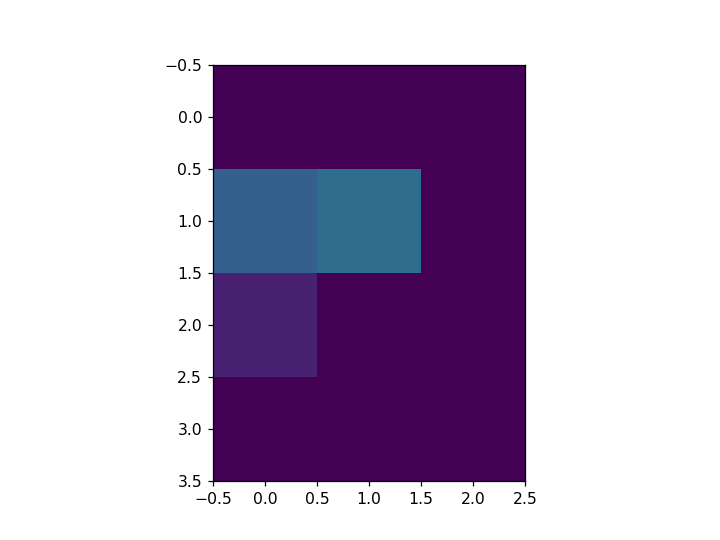

done


In [5]:

fig = plt.figure()
ax = fig.add_subplot(111)



bar = False
if bar:
    ax1 = fig.add_subplot(313)

plt.ion()
fig.show()
fig.canvas.draw()
  
epochs = 50
x_fire = np.array(random.sample(range(1,epochs), epochs // 8))
y_fire = x_fire + 2
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)
    #if 1 in in_stream:
    #   print("In signal")
    out,spikes = model(in_stream, training = True)
    
    if bar:
        ax1.bar(e,out[0], color = "green")
        ax1.bar(e,in_stream[0] / 2, color = "green")

        ax1.bar(e,out[1], color = "blue")
        ax1.bar(e,in_stream[1] / 2, color = "blue")
    
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    if True:
        draw_spikes(spikes, ax, l_dim = 4, n_layers = 3)
        fig.canvas.draw()
        time.sleep(0.1)
print("done")